In [233]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pandas as pd


def load_data_to_df():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    images = df_data.to_numpy()
    correct_images = [im.reshape(64, 64).T for im in images]
    correct_images = np.array(correct_images)
    flattened_correct_images = [im.flatten() for im in correct_images]
    df = pd.DataFrame(flattened_correct_images)
    df["Label"] = df_labels
    
    return df


def load_unified_data():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    df = pd.concat([df_data, df_labels], axis=1)
    df.rename(columns={"x": "Label"}, inplace=True)
    return df


def plot_image_on_ax(ax, image, pixel_size=64, index=""):
    ax.imshow(
        image.reshape(pixel_size, pixel_size),
        cmap="gray",
    )
    ax.set_title(f"{index}", fontsize=30)  # Increase the font size to 16
    ax.axis("off")


def get_image_from_df(df, index):
    return df.iloc[index, :-1].values


def get_all_images_from_df_as_numpy(df):
    # Note: this does not work for the df with blocks
    return df.iloc[:, :-1].to_numpy()


def reshape_into_blocks(images):
    # Reshape each 64x64 image into 16 blocks of 16x16
    # Assuming images.shape == (n_samples, 64, 64)
    n_samples = images.shape[0]
    blocks = images.reshape(n_samples, 4, 16, 4, 16)
    blocks = blocks.swapaxes(2, 3).reshape(n_samples, 16, 256)
    return blocks


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    n_bars = len(data)
    bar_width = total_width / n_bars
    bars = []

    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(
                x + x_offset,
                y,
                width=bar_width * single_width,
                color=colors[i % len(colors)],
            )
        bars.append(bar[0])

    if legend:
        ax.legend(bars, data.keys(), loc="lower center")

In [234]:
df = load_data_to_df()

In [235]:
# Count the number of dogs and cats
dogs = df[df["Label"] == 1]
n_dogs = dogs.shape[0]
print(f"Number of dogs: {n_dogs}")


cats = df[df["Label"] == 0]
n_cats = cats.shape[0]
print(f"Number of cats: {n_cats}")

Number of dogs: 101
Number of cats: 97


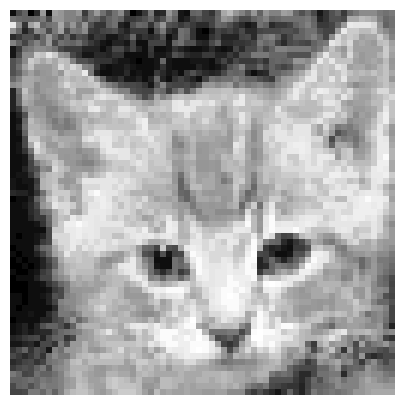

In [236]:
# Plot the first image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_image_on_ax(ax, get_image_from_df(df, 0))
plt.show()

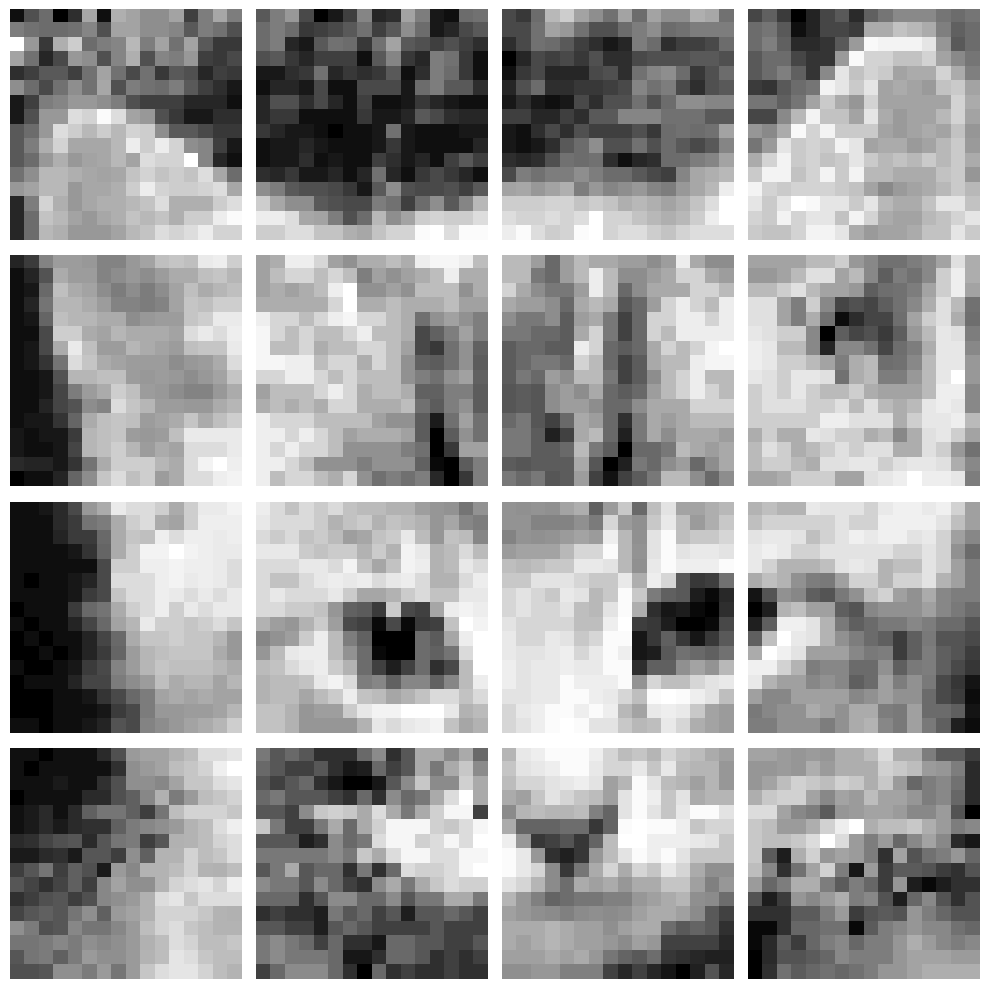

In [237]:
images = get_all_images_from_df_as_numpy(df)
block_images = reshape_into_blocks(images)
first_block_image = block_images[0]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    plot_image_on_ax(ax, first_block_image[i], pixel_size=16)

plt.tight_layout()
plt.show()

In [238]:
block_images.shape
print(f"Block images shape: {block_images.shape}")

Block images shape: (198, 16, 256)


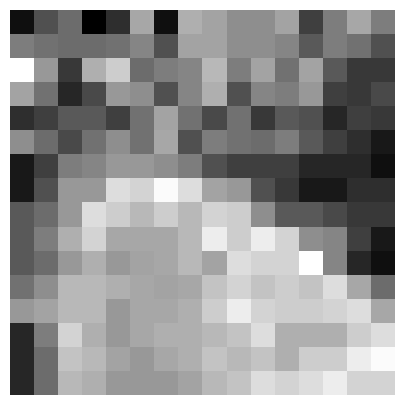

In [239]:
# Plot the first block
first_block = block_images[0][0][:]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_image_on_ax(ax, first_block, pixel_size=16)
plt.show()

In [240]:
# Expand the labels to fit the number of blocks
labels = df["Label"].values
labels = np.repeat(labels, 16)
labels.shape
print(f"Labels shape: {labels.shape}")

Labels shape: (3168,)


In [241]:
blocks = block_images.reshape(-1, 256)   
blocks.shape
print(f"Blocks shape: {blocks.shape}")

Blocks shape: (3168, 256)


In [242]:
# Create a new DataFrame with the blocks and labels
df_blocks = pd.DataFrame(blocks)
df_blocks["Label"] = labels
df_blocks.head(5)

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,Label
0,23,78,102,10,49,152,23,159,149,131,...,149,166,176,198,190,198,211,190,190,0
1,86,116,139,73,10,31,64,123,43,49,...,152,176,190,190,223,227,198,223,223,0
2,73,59,102,166,184,149,131,107,149,102,...,190,198,198,184,176,190,198,198,198,0
3,86,107,78,31,59,86,102,64,107,123,...,166,152,159,159,166,184,184,211,190,0
4,43,64,131,152,152,149,131,131,149,159,...,211,184,198,152,166,211,211,227,232,0


In [243]:
# Print the number of cats and dogs in the dataset
n_cats = df_blocks[df_blocks["Label"] == 0].shape[0]
n_dogs = df_blocks[df_blocks["Label"] == 1].shape[0]
print(f"Number of cat blocks: {n_cats}")
print(f"Number of dog blocks: {n_dogs}")

Number of cat blocks: 1552
Number of dog blocks: 1616


In [244]:
# Add a column to the dataframe that contains the block index
df_blocks["Block"] = df_blocks.index % 16
df_blocks.head(5)

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Label,Block
0,23,78,102,10,49,152,23,159,149,131,...,166,176,198,190,198,211,190,190,0,0
1,86,116,139,73,10,31,64,123,43,49,...,176,190,190,223,227,198,223,223,0,1
2,73,59,102,166,184,149,131,107,149,102,...,198,198,184,176,190,198,198,198,0,2
3,86,107,78,31,59,86,102,64,107,123,...,152,159,159,166,184,184,211,190,0,3
4,43,64,131,152,152,149,131,131,149,159,...,184,198,152,166,211,211,227,232,0,4


In [245]:
classifiers = {
    "kNN": KNeighborsClassifier(n_neighbors=11),
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Increase max_iter
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000)  # Increase max_iter
}

In [246]:
selected_blocks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

block_accuracy_per_classifier = {
    "kNN": [],
    "Logistic Regression": [],
    "SVM": [],
    "Random Forest": [],
    "Neural Network": [],
}

for block in selected_blocks:
    block_data = df_blocks[df_blocks["Block"] == block]

    X = block_data.iloc[:, :-2].values
    y = block_data["Label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train a classifier
    for clf_string, clf in classifiers.items():
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)

        block_accuracy_per_classifier[clf_string].append(acc)

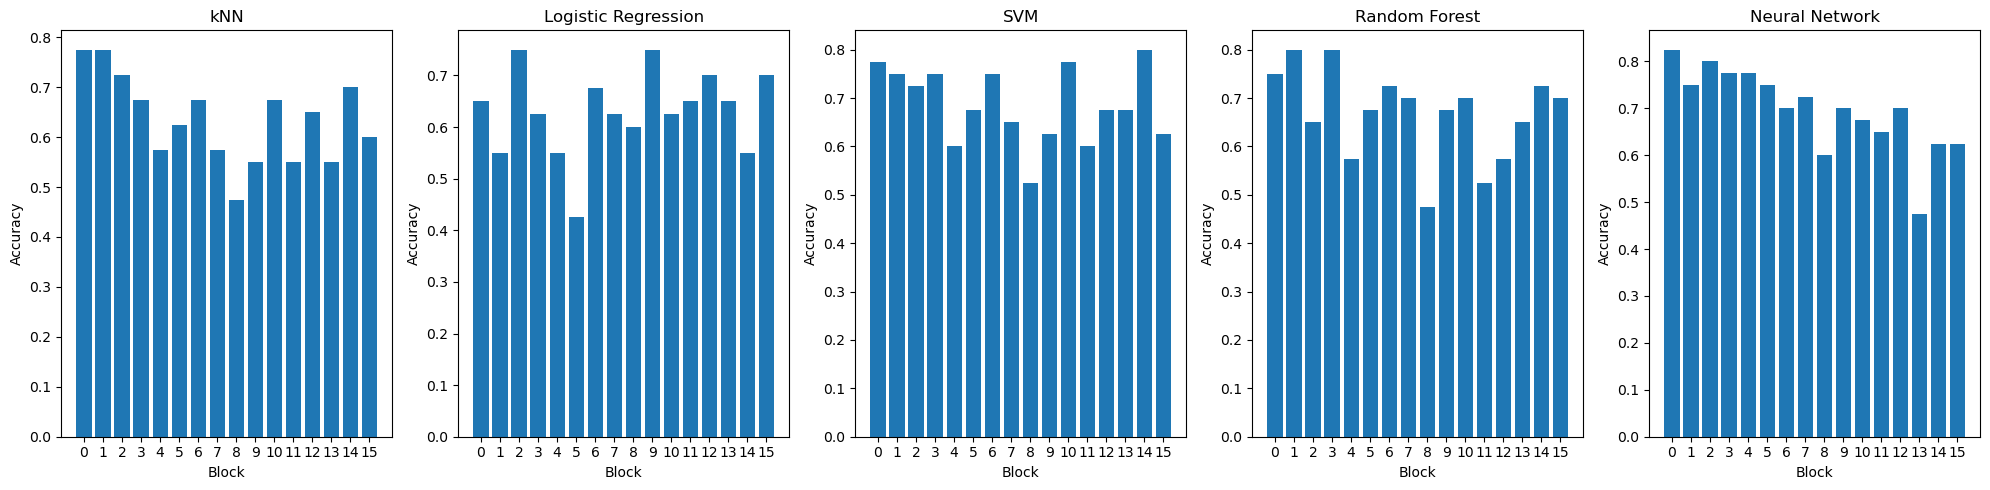

In [247]:
# For each classifier plot the accuracy for each block using a barplot
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.ravel()

for i, (clf, accs) in enumerate(block_accuracy_per_classifier.items()):
    ax = axes[i]
    ax.bar(selected_blocks, accs)
    ax.set_title(clf)
    ax.set_xlabel("Block")
    ax.set_ylabel("Accuracy")
    ax.xaxis.set_ticks(selected_blocks)

plt.tight_layout()
plt.show()

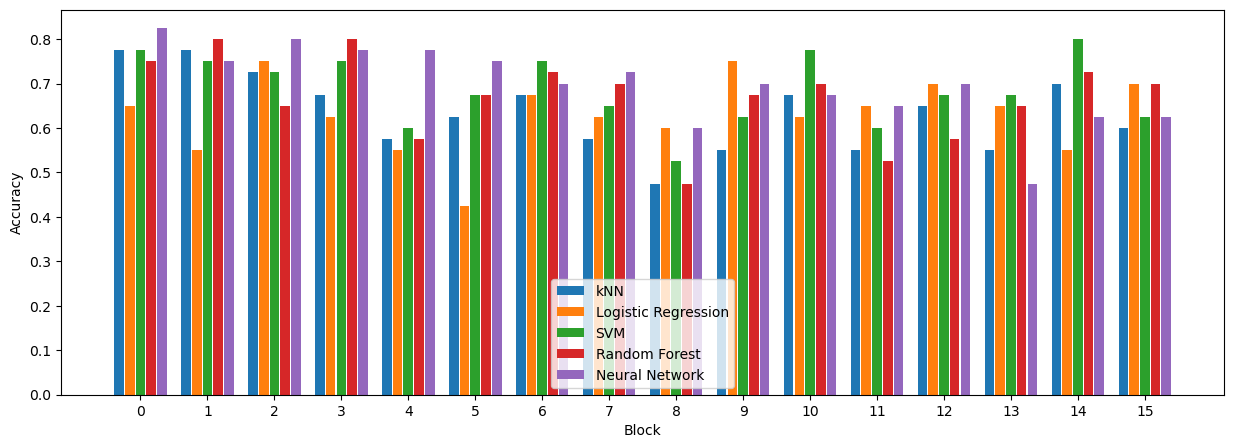

In [248]:
data = {
    "kNN": block_accuracy_per_classifier["kNN"],
    "Logistic Regression": block_accuracy_per_classifier["Logistic Regression"],
    "SVM": block_accuracy_per_classifier["SVM"],
    "Random Forest": block_accuracy_per_classifier["Random Forest"],
    "Neural Network": block_accuracy_per_classifier["Neural Network"],
}

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
bar_plot(ax, data, total_width=0.8, single_width=0.9)
ax.set_xlabel("Block")
ax.set_ylabel("Accuracy")
ax.xaxis.set_ticks(selected_blocks)
plt.show()